# Introduction : This project is for me to practice with tools :



I will get the dataset from https://cocl.us/new_york_dataset



In [1]:
import pandas as pd # For dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np # For handle data as arrays
import folium  # For geographical map
import requests
import re

from requests import get
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.distance import great_circle


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

print("Import complete")

Import complete


## Variables 

In [55]:
#To get the data from Foursquare use your identification credencials here

CLIENT_ID = "XX"
CLIENT_SECRET = "XX"
VER = "XX"


## Functions to be called later in the program

In [56]:
def get_coordinates(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VER, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]["groups" ][0]["items"]
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row["venue"]["id"]
            venue_name=row["venue"]["name"]
            venue_category=row["venue"]["categories"][0]["name"]
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=["ID","Name","Category"]
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = "https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}".format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET,  
            VER)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results["response"]["venue"]
    venue_details=[]
    try:
        venue_id=venue_data["id"]
        venue_name=venue_data["name"]
        venue_likes=venue_data["likes"]["count"]
        venue_rating=venue_data["rating"]
        venue_tips=venue_data["tips"]["count"]
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=["ID","Name","Likes","Rating","Tips"]
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url = "https://cocl.us/new_york_dataset"
    resp = requests.get(url).json()
    # all data is present in features label
    features=resp["features"]
    # define the dataframe columns
    column_names = ["Borough", "Neighborhood", "Latitude", "Longitude"] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data["properties"]["borough"] 
        neighborhood_name = data["properties"]["name"]
        neighborhood_latlon = data["geometry"]["coordinates"]
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({"Borough": borough,
                                          "Neighborhood": neighborhood_name,
                                          "Latitude": neighborhood_lat,
                                          "Longitude": neighborhood_lon}, ignore_index=True)
    return new_york_data

## Getting the data and storing as dataframe

In [4]:
df_new_york = get_new_york_data()
df_new_york.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## First visualization of the data

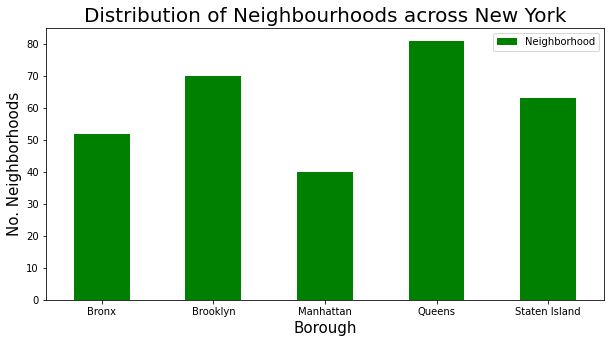

In [57]:
color = "green"
df_new_york.groupby("Borough")["Neighborhood"].count().plot.bar(figsize=(10,5), color=color)

plt.title("Distribution of Neighbourhoods across New York", fontsize = 20)
plt.xlabel("Borough", fontsize = 15)
plt.ylabel("No. Neighborhoods",fontsize = 15)
plt.xticks(rotation = "horizontal")
plt.legend()
plt.show()

In [58]:
# queens has most neighborhoods
# prepare neighborhood list that contains taco restaurants

column_names=["Borough", "Neighborhood", "ID","Name"]
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1

for row in df_new_york.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_restaurants=venues[venues["Category"]=="Mexican Restaurant"]   
    print("(",count,"/",len(df_new_york), ")" , "Mexican Restaurants in " + Neighborhood + ", " + Borough + ":" +str(len(mexican_restaurants)))
    print(row)
    for resturant_detail in mexican_restaurants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({"Borough": Borough,
                                                "Neighborhood": Neighborhood, 
                                                "ID": id,
                                                "Name" : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Mexican Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Mexican Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Mexican Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Mexican Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Mexican Restaurants in Kingsbridge, Bronx:3
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Mexican Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Mexican Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Mexican Restaurants in Norwood, Bronx:0
['

In [59]:
mexican_rest_ny.to_csv("mexican_rest_ny_tocsv1.csv")

## Store to CSV to avoid running out of calls to Foursquare

In [60]:
mexican_ny = pd.read_csv("mexican_rest_ny_tocsv1.csv")

In [61]:
mexican_rest_ny.tail()

,Borough,Neighborhood,ID,Name
115,Brooklyn,Fulton Ferry,4f69f2b76d86f87117bb13ab,Gran Eléctrica
116,Brooklyn,Dumbo,4f69f2b76d86f87117bb13ab,Gran Eléctrica
117,Brooklyn,Homecrest,507e08fae4b0998ce3421276,El Mexicano Restaurante & Cafe Inc
118,Brooklyn,Homecrest,4a3ada26f964a5205fa01fe3,La Villita Mexican Restaurant
119,Bronx,Kingsbridge Heights,4b403740f964a520e8b625e3,Montezuma Mexican Restaurant


In [62]:
mexican_rest_ny.shape

(120, 4)

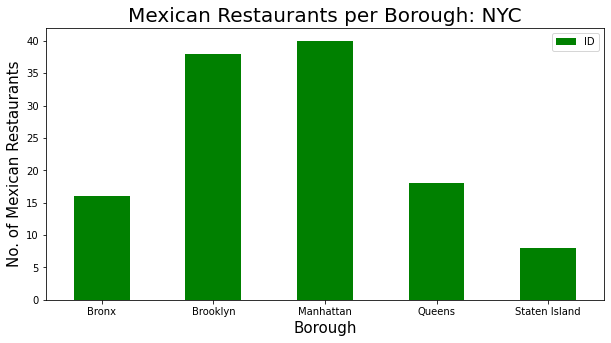

In [63]:
mexican_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=color)
plt.title('Mexican Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Mexican Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

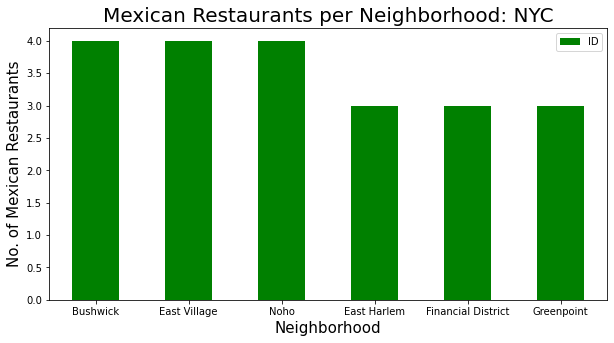

In [64]:
NOofNeigh = 6 # top number for graphing all the same past 6
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=color)
plt.title('Mexican Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Mexican Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [65]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Bushwick']

,Borough,Neighborhood,ID,Name
26,Brooklyn,Bushwick,507c9d44e4b07390823b8d98,Taqueria Sofia
27,Brooklyn,Bushwick,54a5a765498e6b7e2ce128c8,El Kucho
28,Brooklyn,Bushwick,4a79c17ef964a52093e71fe3,El Sol de Cholula
29,Brooklyn,Bushwick,4dd6d110814d85e931ff48e4,Zefe's Mexican Restaurant


In [66]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
mexican_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '6009d1b30d13d94ee19c94d9'}, 'response': {'venue': {'id': '5217dd2811d2d06ccafb77d3', 'name': 'Estrellita Poblana V', 'contact': {'phone': '7188843825', 'formattedPhone': '(718) 884-3825'}, 'location': {'address': '240 W 231st St', 'lat': 40.879687039717524, 'lng': -73.906256832975, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879687039717524, 'lng': -73.906256832975}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['240 W 231st St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/estrellita-poblana-v/5217dd2811d2d06ccafb77d3', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://www.estrel

KeyError: 'venue'

In [67]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny_csv.csv') 

In [68]:
mexican_rest_stats_ny.shape

(50, 7)

### We've got stats from totally 49 Mexican restaurants in the New York area

In [69]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.6+ KB


In [70]:
mexican_rest_stats_ny["Likes"] = mexican_rest_stats_ny["Likes"].astype("float64")
mexican_rest_stats_ny["Tips"] = mexican_rest_stats_ny["Tips"].astype("float64")
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.0+ KB


In [71]:
mexican_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,45.940000,7.286000,18.920000
std,57.595851,1.701021,21.573642
min,0.000000,0.000000,0.000000
25%,9.250000,6.900000,3.000000
50%,24.000000,7.600000,8.000000
75%,54.000000,8.100000,35.250000
max,250.000000,9.100000,88.000000


In [72]:
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              5ae8ed8eb3c961002b3360da
Name                             Oxomoco
Likes                                250
Rating                                 9
Tips                                  54
Name: 16, dtype: object

Most liked restaurant "Oxomoco" in Greenpoint, Brooklyn

In [73]:
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                131
Rating                               9.1
Tips                                  73
Name: 6, dtype: object

Highest rated restaurant with 9.1 is Taqueria Tlaxcali in Parkchester, Bronx

## Visualize and identify the neighborhood with the maximum average rating of its restaurants

In [74]:
ny_neighborhood_stats=mexican_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
20,Parkchester,9.100000
5,Chinatown,8.650000
17,North Side,8.400000
28,Westchester Square,8.050000
22,Prospect Heights,8.033333
25,South Side,8.000000
3,Brooklyn Heights,7.950000
4,Bushwick,7.900000
14,Kingsbridge,7.833333
12,Greenpoint,7.800000


### Above we can see Parkchester has highest average rating of the Neighborhoods

In [75]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.450000
1,Brooklyn,7.378788
0,Bronx,7.000000


### Visualization of the data

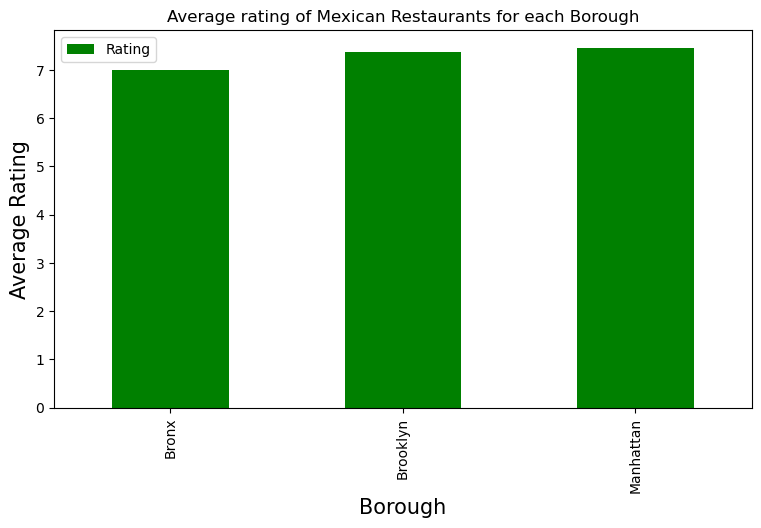

In [76]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Mexican Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=color)
plt.legend()
plt.show()

In [77]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Chinatown,8.650000
17,North Side,8.400000
20,Parkchester,9.100000
22,Prospect Heights,8.033333
25,South Side,8.000000
28,Westchester Square,8.050000


### Merge dataset with New York dataset containing coordinates for different areas

In [78]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df_new_york, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chinatown,40.715618,-73.994279,8.650000
1,Brooklyn,North Side,40.714823,-73.958809,8.400000
2,Bronx,Parkchester,40.837938,-73.856003,9.100000
3,Brooklyn,Prospect Heights,40.676822,-73.964859,8.033333
4,Brooklyn,South Side,40.710861,-73.958001,8.000000
5,Bronx,Westchester Square,40.840619,-73.842194,8.050000


## Time to show the data on a map!

In [79]:
get_coordinates("New York")
# create map and display it
ny_map = folium.Map(location=get_coordinates("New York"), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [80]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Conclusion
### We have a lot of Mexican resturants located in the southern part of Manhattan and northern part of Brooklyn. As far as rating goes we've plotted the ones with 8 rating and above. It looks like there is a lot of competition in the area around New York for Mexican food places. It will be a rough market to compete in as there are several 8+ rated places.